In [22]:
# Explore some statistics about user rating activity in the MovieLens datasets
import csv
import os
import sys 
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

target_dataset = 'ml-100k'  # Change this to explore other datasets

df = pd.read_csv(f'../movie-engine-data/raw/{target_dataset}/ratings.csv')

user_activity = df.groupby('userId').size()
rating_counts = df.groupby('rating').size()

rating_mean = df['rating'].mean()
rating_median = df['rating'].median()

In [16]:
# Show summary statistics for User Activity with a header that names the dataset being used
print(f"User Rating Activity Statistics for {target_dataset.upper()} Dataset:")
print("-------------------------------")
user_activity.describe()

User Rating Activity Statistics for ML-100K Dataset:
-------------------------------


count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
dtype: float64

In [31]:
# Show summary statistics for Rating Counts with a header that names the dataset being used
print(f"\nRating Counts Statistics for {target_dataset.upper()} Dataset:")
print("-------------------------------\n")
rating_counts.describe()
print(f"Mean Rating: {rating_mean:.2f}")
print(f"Median Rating: {rating_median:.2f}")
print(f"Mode Rating: {rating_counts.idxmax()}")

total_ratings = rating_counts.sum()
# Print rating counts per rating value
for rating_value, count in rating_counts.items():
    print(f"{rating_value}: {count} ({(count / total_ratings) * 100:.2f}%)")




Rating Counts Statistics for ML-100K Dataset:
-------------------------------

Mean Rating: 3.50
Median Rating: 3.50
Mode Rating: 4.0
0.5: 1370 (1.36%)
1.0: 2811 (2.79%)
1.5: 1791 (1.78%)
2.0: 7551 (7.49%)
2.5: 5550 (5.50%)
3.0: 20047 (19.88%)
3.5: 13136 (13.03%)
4.0: 26818 (26.60%)
4.5: 8551 (8.48%)
5.0: 13211 (13.10%)


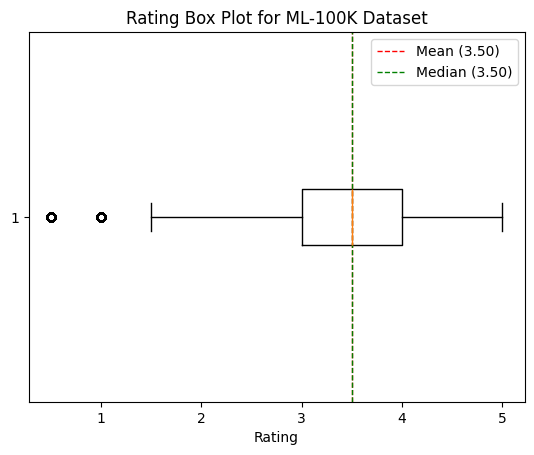

In [23]:
# Box plot of ratings, with mean and median lines.
plt.boxplot(df['rating'], vert=False)
plt.xlabel('Rating')
plt.title(f'Rating Box Plot for {target_dataset.upper()} Dataset')
plt.axvline(rating_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean ({rating_mean:.2f})')
plt.axvline(rating_median, color='green', linestyle='dashed', linewidth=1, label=f'Median ({rating_median:.2f})')
plt.legend()
plt.show()

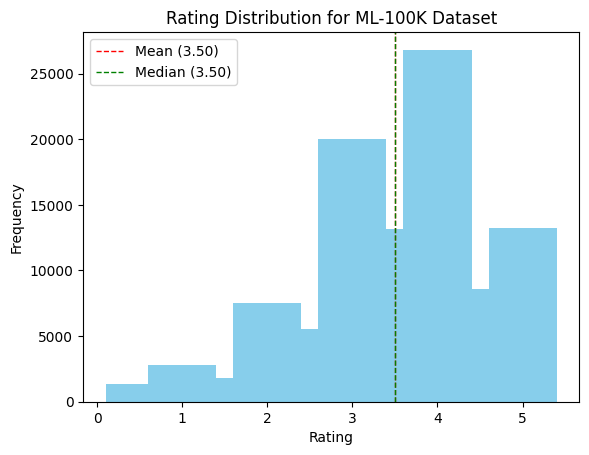

In [21]:
# Histogram of frequencies of rating numbers, with mean and median lines.
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title(f'Rating Distribution for {target_dataset.upper()} Dataset')
plt.axvline(rating_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean ({rating_mean:.2f})')
plt.axvline(rating_median, color='green', linestyle='dashed', linewidth=1, label=f'Median ({rating_median:.2f})')
plt.legend()
plt.show()



Rating Statistics by Genre for ML-100K Dataset:
-------------------------------

                    count  mean  median  mode
genre                                        
Drama               41928  3.66     4.0   4.0
Comedy              39053  3.38     3.5   4.0
Action              30635  3.45     3.5   4.0
Thriller            26452  3.49     3.5   4.0
Adventure           24161  3.51     3.5   4.0
Romance             18124  3.51     3.5   4.0
Sci-Fi              17243  3.46     3.5   4.0
Crime               16681  3.66     4.0   4.0
Fantasy             11834  3.49     3.5   4.0
Children             9208  3.41     3.5   4.0
Mystery              7674  3.63     4.0   4.0
Horror               7291  3.26     3.5   4.0
Animation            6988  3.63     4.0   4.0
War                  4859  3.81     4.0   4.0
Musical              4138  3.56     3.5   4.0
Western              1930  3.58     4.0   4.0
Documentary          1219  3.80     4.0   4.0
Film-Noir             870  3.92     4.0   4.

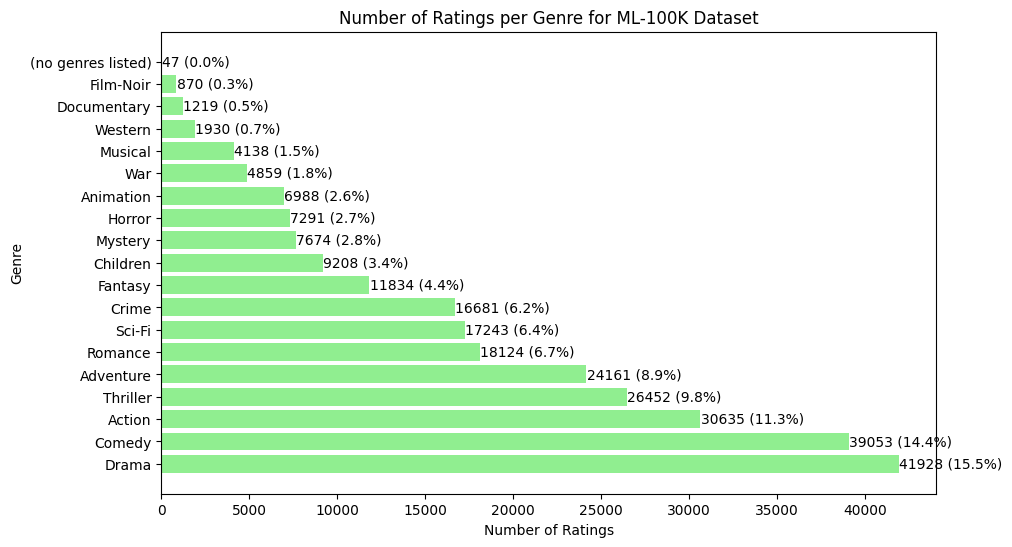

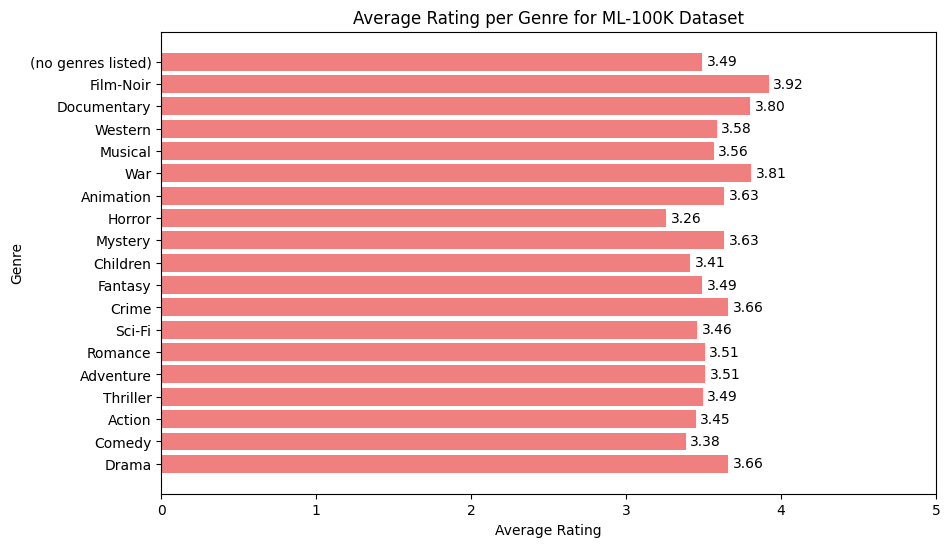

In [35]:
# Pull in data from the processed movies and map to the processed ratings
movies_df = pd.read_csv(f'../movie-engine-data/processed/{target_dataset}/movies.csv')
ratings_df = pd.read_csv(f'../movie-engine-data/processed/{target_dataset}/ratings.csv')
# merge with left join to keep ratings even if movie metadata is missing
merged = pd.merge(ratings_df, movies_df, on='movieId', how='left')

# Per-genre loop approach (one-hot encoded genre columns).
# Decide which columns are genres. Extend non_genre_cols if your movies.csv has extra metadata columns.
non_genre_cols = {'movieId', 'title', 'year'}  # adjust if needed
candidate_cols = [c for c in movies_df.columns if c not in non_genre_cols]

import numpy as np
def _looks_like_genre(col: str) -> bool:
    # Heuristic: treat as genre column if values are subset of {0,1,True,False} (or column is empty)
    s = movies_df[col].dropna()
    if s.empty:
        return True
    vals = set(s.unique())
    return vals.issubset({0, 1, True, False})

genre_cols = [c for c in candidate_cols if _looks_like_genre(c)]

# Compute per-genre statistics by iterating genres (easy to understand and memory-light).
rows = []
for g in genre_cols:
    # select ratings for movies that have this genre flagged (==1 or True)
    sel = merged.loc[merged.get(g) == 1, 'rating'].dropna()
    if sel.empty:
        cnt = 0
        mean = np.nan
        median = np.nan
        mode = np.nan
    else:
        cnt = int(sel.count())
        mean = float(sel.mean())
        median = float(sel.median())
        mode = float(sel.mode().iloc[0]) if not sel.mode().empty else np.nan
    rows.append({'genre': g, 'count': cnt, 'mean': mean, 'median': median, 'mode': mode})

import pandas as _pd
genre_stats = _pd.DataFrame(rows).set_index('genre').sort_values('count', ascending=False)
print(f"\nRating Statistics by Genre for {target_dataset.upper()} Dataset:")
print("-------------------------------\n")
print(genre_stats.round(2))

# Generate a bar chart of the number of ratings per genre, with the count values displayed on top of each bar
# Add the percentage of total ratings for each genre
total_ratings = genre_stats['count'].sum()
genre_stats['percentage'] = (genre_stats['count'] / total_ratings) * 100
plt.figure(figsize=(10, 6))
plt.barh(genre_stats.index, genre_stats['count'], color='lightgreen')
plt.xlabel('Number of Ratings')
plt.ylabel('Genre')
plt.title(f'Number of Ratings per Genre for {target_dataset.upper()} Dataset')
for i, v in enumerate(genre_stats['count']):
    plt.text(v + 3, i, str(v) + f" ({genre_stats['percentage'].iloc[i]:.1f}%)", ha='left', va='center')
plt.show()

# Generate a bar chart of the average rating per genre, with the mean values displayed on top of each bar
plt.figure(figsize=(10, 6))
plt.barh(genre_stats.index, genre_stats['mean'], color='lightcoral')
plt.ylabel('Genre')
plt.xlabel('Average Rating')
plt.title(f'Average Rating per Genre for {target_dataset.upper()} Dataset')
for i, v in enumerate(genre_stats['mean']):
    plt.text(v + 0.03, i, f"{v:.2f}", ha='left', va='center')
plt.xlim(0, 5)  # Ratings are typically between 0 and 5
plt.show()